In [4]:

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


train_dir='../../day4/dataset/cats_and_dogs_small/train'
validation_dir='../../day4/dataset/cats_and_dogs_small/validation'
test_dir='../../day4/dataset/cats_and_dogs_small/test'

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

# 검증 데이터는 argumentation 금지
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


1 Physical GPUs, 1 Logical GPUs


In [5]:

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지의 크기를 150 × 150로 변경합니다
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하므로 이진 레이블이 필요합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:

## back born
conv_base=tf.keras.applications.VGG16(
                  weights='imagenet',  ## 모델을 포기화할 checkpoint 지정 (여기는 imagenet 확습 모델)
                  include_top=False   ## 네트워크 최상위 FC(분류기)를 포함할지 안할지 지정 (imagenet은 1000개 클래스이므로 지금 개 고양이 에선 사용x)
                  )  ## 네트워크에 입력할 이미지 텐서 크기
## 모델 구성 확인하기.
## 확인하면 최종출력은  (4,4,512)이다. 즉, 4x4x512=8192인 (batch,8192) 인 FC를 만들어 연결해주어야한다. 그러나 fc만 할거면 Flatten()해서 입력
## 이제 이거를 FC에 연결하여 학습을 하여 개 고양이 분류 모델을 완성한다.
conv_base.summary()

## 모델
input_Layer = tf.keras.layers.Input(shape=(150,150,3))
x=conv_base(input_Layer)
x=tf.keras.layers.Flatten()(x)
x= tf.keras.layers.Dense(512, activation='relu')(x)
Out_Layer= tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs=[input_Layer], outputs=[Out_Layer])
# model.summary()

print(' 동결하기 전 conv_base를훈련되는 가중치의 수:',
      len(model.trainable_weights))

## fully connected 부분을 제외하고 학습하지 마라! fully conntected = classifier
conv_base.trainable = False   ## True면 back의 초기값이 가지고있던 웨이트로해서 학습 False면 bakcborn뒤의 모델만 학습

#특정 layer별로 학습을 enable / disable하는 예제코드
#print(conv_base.layers)
#set_trainable = False
#for layer in conv_base.layers:
#    if layer.name == 'block5_conv1':  ## block5_conv1이후의 모든 레이어들은 학습이 된다.
#        set_trainable = True
#    if set_trainable:
#        layer.trainable = True
#    else:
#        layer.trainable = False

print('conv_base를 동결한 후 훈련되는 가중치의 수:',
      len(model.trainable_weights))  ## dence layer가 2개 선언. 각 layer 마다 w,b 파라미터 2개가 있고, 2개의 레이어만 학습하므로 총 4개 파라미터만 학습

model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [8]:

loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.RMSprop(learning_rate=0.0001)
metric=tf.keras.metrics.binary_accuracy

model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

model.save('cats_and_dogs_small_3.h5')


/home/dalu/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
100/100 - 51s - loss: 0.4713 - binary_accuracy: 0.7820 - val_loss: 0.3586 - val_binary_accuracy: 0.8290
Epoch 2/30
100/100 - 42s - loss: 0.3395 - binary_accuracy: 0.8355 - val_loss: 0.2513 - val_binary_accuracy: 0.8930
Epoch 3/30
100/100 - 42s - loss: 0.2922 - binary_accuracy: 0.8810 - val_loss: 0.2569 - val_binary_accuracy: 0.8950
Epoch 4/30
100/100 - 42s - loss: 0.2800 - binary_accuracy: 0.8815 - val_loss: 0.2351 - val_binary_accuracy: 0.9070
Epoch 5/30
100/100 - 42s - loss: 0.2584 - binary_accuracy: 0.8860 - val_loss: 0.2537 - val_binary_accuracy: 0.8950
Epoch 6/30
100/100 - 42s - loss: 0.2299 - binary_accuracy: 0.9055 - val_loss: 0.3296 - val_binary_accuracy: 0.8630
Epoch 7/30
100/100 - 42s - loss: 0.2369 - binary_accuracy: 0.8990 - val_loss: 0.2398 - val_binary_accuracy: 0.8980
Epoch 8/30
100/100 - 42s - loss: 0.2289 - binary_accuracy: 0.9045 - val_loss: 0.2500 - val_binary_accuracy: 0.8990
Epoch 9/30
100/100 - 42s - loss: 0.2117 - binary_accuracy: 0.9065 - val_loss: 0.

In [13]:
print(history.history.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


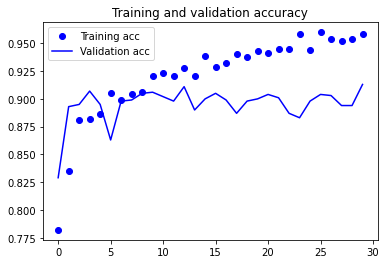

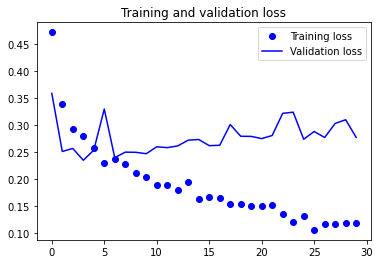

In [14]:

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
import matplotlib.pyplot as plt
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()